#Import libraries

In [1]:
%pylab inline
import matplotlib
import seaborn

import random
import pandas as pd
import numpy as np
from yahoo_finance import Share
import matplotlib
import datetime
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib

Populating the interactive namespace from numpy and matplotlib


#Create and format dataframe

In [2]:
def get_dailyret(ser):
    return (ser.shift(-1) - ser)/ser


def get_smooth_val(ser, lookback):
    ###does not include today so that residual is relevant for return
    ls = []
    bs = []
    lr = LinearRegression()
    for i in range(len(ser)):
        a = ser[i-lookback:i].tolist()
        #print(a)
        if len(a) == 0:
            ls.append(np.nan)
            bs.append(np.nan)
        else:
            a = lr.fit(np.array(range(lookback)).reshape(lookback,1),np.array(a).reshape((lookback,1)))
            ls.append(float(a.predict(lookback)[0]))
            bs.append(float(a.coef_))
    return ls, bs
    
def get_dfs(strat):
    data = pd.DataFrame(Share(strat).get_historical('2010-05-02', '2015-12-12'))
    print('fetched data')
    data.Date = [datetime.strptime(data.Date.iloc[i], '%Y-%m-%d') for i in data.index]
    data.index = data.Date
    data = data.iloc[::-1]
    data.Close = [float(x) for x in data.Close]
    data['smooth'], data['trend'] = get_smooth_val(data.Close, 50)
    data['resid'] = data.Close-data['smooth']
    data['dailyrets'] = get_dailyret(data.Close)
    return data

In [3]:
def main1():
    numstrats = 0
    tickdict ={}
    for ticker in ['GS']:
        print(numstrats)
        print(ticker)
        
        tickdict[ticker] = get_dfs(ticker)

        numstrats+=1
        
    return  tickdict

In [4]:
tickdict = main1()

0
GS
fetched data


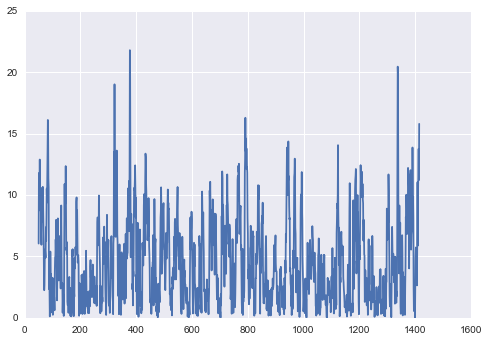

In [8]:
plot(tickdict['GS'].resid)

In [40]:
absresid = pd.Series(tickdict['GS'].resid)
rs = []
xs = []
for i in range(30):
    thresh = i*.5
    rs.append(thresh)
    
    ser=(absresid.shift(1)-thresh)*(absresid-thresh)
    count = sum(ser<0)
    ser=(absresid.shift(1)+thresh)*(absresid+thresh)
    count2 = sum(ser<0)
    xs.append(count+count2)
    
    

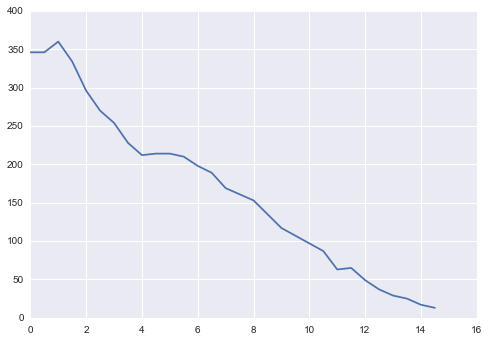

In [41]:
plot(rs,xs)


In [32]:
absresid = pd.Series(abs(tickdict['GS'].resid)-7).shift(1)*pd.Series(abs(tickdict['GS'].resid)-7)

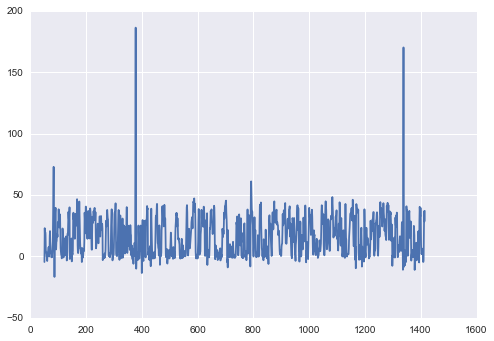

In [33]:
plot(absresid)

In [25]:
sum(absresid<0)

260

#calculate results

In [46]:


def sweetspotuser2(ticker, tickdict):
    cs=[]
    eqs=[]
    data = tickdict[ticker]
    data['yesteresid'] = data['resid'].shift(1)
    data['residvar'] = [np.std(data.resid.iloc[i-300:i]) for i in range(len(data))]
    for x in range(30):
        c = .1*x
        #thresh = c*np.std(data['resid'])
        data['stratret'] = trade_logic(data, c)
        eqcurve = np.cumprod(3*data.stratret+1)
        cs.append(c)
        eqs.append(eqcurve[-2])#50])            #set to 250 for OOS
    matplotlib.pyplot.plot(cs,eqs)
    matplotlib.pyplot.show()
    #plot(cs,eqs)
    #show()
    data  = tickdict[ticker]#.tail(250)         #remove comment for OOS
    #if max(eqs)<1.5:
     #   print('nein!')
      #  return 
    c = cs[np.argmax(eqs)]
    #c=2
    data['stratret'] = trade_logic(data, c)
    eqcurve = np.cumprod(3*data.stratret+1)
    return eqcurve[-2], data['stratret']
    
            
            
    
def trade_logic(data, c):
    position = 'out'
    thresh = 0
    rets = []
    for i in range(data.shape[0]):
        threshold=data['residvar'].iloc[i]*c
        #threshold = 11
        if position == 'out':
            if data['resid'].iloc[i]>threshold:
                if data['resid'].iloc[i]<data['yesteresid'].iloc[i]:
                    position = 'short'
                    thresh = data['yesteresid'].iloc[i]
                    rets.append(-data['dailyrets'].iloc[i])
                    continue
                else:
                    rets.append(0)
                    continue
                    
            if data['resid'].iloc[i]<-threshold:
                if data['resid'].iloc[i]>data['yesteresid'].iloc[i]:
                    position = 'long'
                    thresh = data['yesteresid'].iloc[i]
                    rets.append(data['dailyrets'].iloc[i])
                    continue
                else:
                    rets.append(0)
                    continue
            
            else:
                rets.append(0)
                continue
               
        if position == 'long':
            if data['resid'].iloc[i]>0:
                position = 'out'
                rets.append(0)
                continue
            if data['resid'].iloc[i]<thresh:
                position = 'out'
                rets.append(0)
                continue
            else:
                rets.append(data['dailyrets'].iloc[i])
                continue
        if position == 'short':
            if data['resid'].iloc[i]<0:
                position = 'out'
                rets.append(0)
                continue
            if data['resid'].iloc[i]>thresh:
                position = 'out'
                rets.append(0)
                continue
            else:
                rets.append(-data['dailyrets'].iloc[i])
                continue
                
    return pd.Series(rets, index = data.index)


def main3(tickdict, plot=True):
    def dd(pnl):
        max_accum = np.maximum.accumulate(pnl)
        max_curr_df = np.subtract(max_accum,pnl)
        #max_drawdown = np.amax(max_curr_df)
        return max(max_curr_df)
    
    portf = []
    porteq = pd.Series()
    numstrats = 0
    dds=[]
    for key in tickdict:
        print('')
        print(numstrats)
        
        print('symbol: %s: ' % key)

        #r, e = sweetspotuser2(key, tickdict)
        try:
            r, e = sweetspotuser2(key, tickdict)
        except:
            continue
            
        numstrats+=1
            
            
        #print('return: %s' % r)
        portf.append(r)
        #print('portfolio ret: %s' % np.mean(portf)-1)

        if numstrats ==1:
            porteq = e
        else:
            porteq =((numstrats-1)* porteq+e)/numstrats
        #print('portfolio ret: %s' %np.prod(3*e+1))
        #print(np.prod(3*porteq+1))
        portcurve = np.cumprod(3*porteq+1)
        print('portfolio ret: %s' % (portcurve[-2]-1))
        dd1 = dd(np.cumprod(3*e+1))
        dds.append(dd1)
        pvol = np.std(3*porteq)*15.8745
        print('portfolio vol: %s' %pvol)
        psharpe = (portcurve[-2]-1)/pvol
        print('port sharpe: %s' % psharpe)

        #print('indv drawdown: %s' % dd1)
        print('portfolio dd: %s' % dd(portcurve))
        promad = (portcurve[-2]-1)/dd(portcurve)
        print('portf romad: %s' %promad)
        #print('avg indv dd: %s' % np.mean(dds))
        #print('avg inv ret: %s' % np.mean(portf))
        iromad = np.mean(portf)-1/np.mean(dds)
        #print('avg indv romad: %s' %iromad)
        
        #if plot==True:
        matplotlib.pyplot.plot(np.cumprod(3*e+1))
        matplotlib.pyplot.show()
        matplotlib.pyplot.plot(portcurve)
        matplotlib.pyplot.show()



0
symbol: GS: 


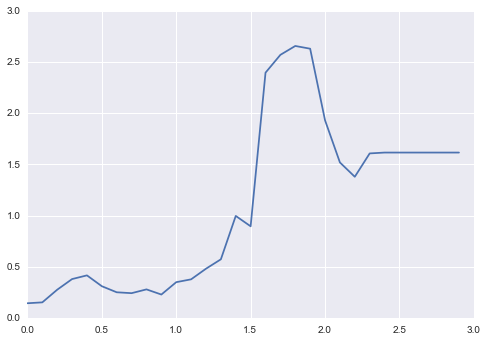

portfolio ret: 1.65722992711
portfolio vol: 0.3251019338349906
port sharpe: 5.09757019148
portfolio dd: 1.4041118279
portf romad: 1.18026918809


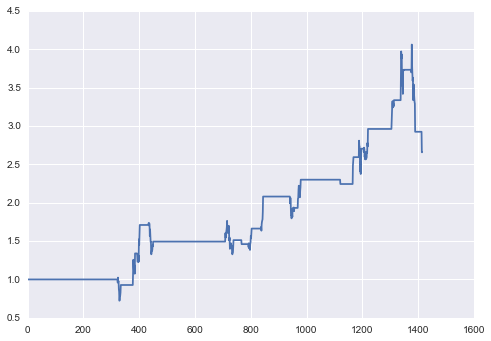

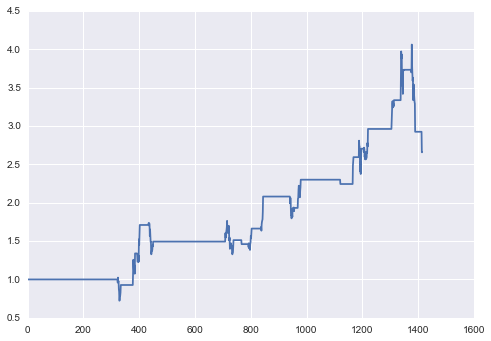

In [47]:
main3(tickdict)

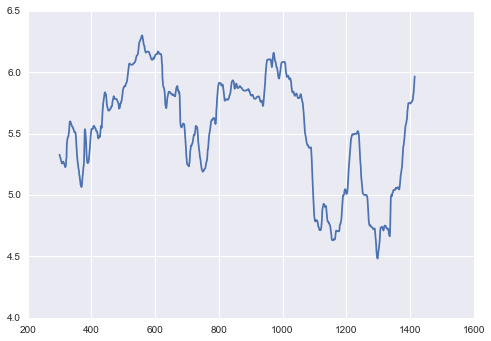

In [35]:
plot(tickdict['GS'].residvar)

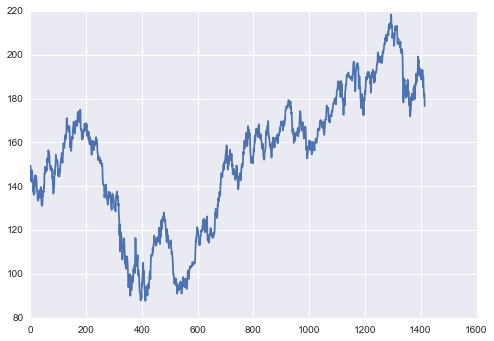

In [27]:
plot(tickdict['GS'].Close)

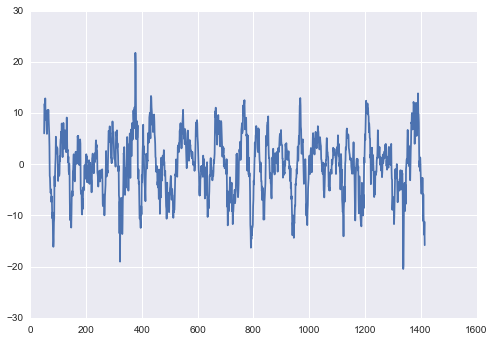

In [5]:
plot(tickdict['GS'].resid)